In [1]:
import pandas as pd
import os
from itables import show
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler

In [2]:
#finding out how many cpu cores you have
!wmic cpu get NumberOfCores,NumberOfLogicalProcessors

#divide the work between the existing cores - 1
os.environ['OMP_NUM_THREADS']='7'

NumberOfCores  NumberOfLogicalProcessors  

4              8                          





# Prepare data set for prediction

In [3]:
traffic = pd.read_csv('traffic_2020-2022_orientation.csv')
weather = pd.read_csv('weather_data_hourly.csv')
emissions = pd.read_csv('emission_huegelstr_hourly.csv')

In [4]:
weather

,timestamp,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad]
0,2018-01-01 00:00:00,1002.5,75.75,8.85,2.50,242.5
1,2018-01-01 01:00:00,1004.0,63.35,10.85,2.35,236.5
2,2018-01-01 02:00:00,1004.5,65.25,10.30,2.35,239.0
3,2018-01-01 03:00:00,1005.0,63.05,10.05,2.30,240.0
4,2018-01-01 04:00:00,1006.0,60.95,9.55,2.45,241.0
...,...,...,...,...,...,...
50070,2023-09-18 06:00:00,1006.0,93.90,18.15,0.90,170.5
50071,2023-09-18 07:00:00,1006.5,88.10,18.50,0.90,186.5
50072,2023-09-18 08:00:00,1007.0,83.40,19.15,0.85,161.5
50073,2023-09-18 09:00:00,1007.0,78.10,20.10,1.20,174.5


In [5]:
emissions

,timestamp,Benzol,CO,m-/p-Xylol,o-Xylol,"PM2,5",PM10,NO2,NO,Toluol
0,2018-01-01 00:00:00,0.82,0.25,0.22,0.22,NaN,169.50,21.65,19.80,0.46
1,2018-01-01 01:00:00,1.32,0.19,0.22,0.22,NaN,88.70,15.40,6.60,0.52
2,2018-01-01 02:00:00,0.35,0.16,0.22,0.22,NaN,23.80,13.55,5.95,0.19
3,2018-01-01 03:00:00,0.37,0.17,0.22,0.22,NaN,23.75,12.25,5.70,0.31
4,2018-01-01 04:00:00,0.34,0.17,0.22,0.22,NaN,16.20,11.85,5.00,0.19
...,...,...,...,...,...,...,...,...,...,...
50070,2023-09-18 06:00:00,0.18,NaN,0.54,0.22,9.00,20.55,11.50,2.95,0.90
50071,2023-09-18 07:00:00,0.21,NaN,0.63,0.22,9.25,20.80,17.35,7.75,0.88
50072,2023-09-18 08:00:00,0.29,NaN,1.47,0.63,8.20,18.70,20.55,10.15,1.96
50073,2023-09-18 09:00:00,0.24,NaN,0.76,0.36,7.80,18.60,19.00,8.85,1.86


In [6]:
traffic

,timestamp,east inbound,north inbound,south inbound,west inbound,east outbound,north outbound,south outbound,west outbound
0,2020-06-01 00:00:00,153.0,232.0,224.0,275.0,28.0,206.2,185.0,1346.31
1,2020-06-01 01:00:00,87.0,154.4,142.0,54.0,15.0,125.4,116.0,406.90
2,2020-06-01 02:00:00,56.0,84.8,83.0,25.0,16.0,52.0,68.0,243.41
3,2020-06-01 03:00:00,39.0,52.6,43.0,15.0,3.0,53.4,42.0,272.47
4,2020-06-01 04:00:00,12.0,72.5,50.0,11.0,4.0,38.4,33.0,413.96
...,...,...,...,...,...,...,...,...,...
17536,2022-06-01 20:00:00,90.0,901.3,904.0,589.0,393.0,754.2,712.0,1255.15
17537,2022-06-01 21:00:00,75.0,767.1,652.0,510.0,263.0,591.8,570.0,1023.02
17538,2022-06-01 22:00:00,62.0,567.2,503.0,389.0,194.0,409.6,501.0,844.69
17539,2022-06-01 23:00:00,24.0,324.6,262.0,244.0,120.0,283.2,251.0,509.95


In [7]:
pred_data = traffic.merge(weather, how='left', on= 'timestamp').merge(emissions[['PM10','PM2,5', 'NO2','timestamp']], how='left', on= 'timestamp')
show(pred_data)

df = pred_data.copy()

In [8]:
df.index = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df[:26]

,timestamp,east inbound,north inbound,south inbound,west inbound,east outbound,north outbound,south outbound,west outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],PM10,"PM2,5",NO2
timestamp,,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,2020-06-01 00:00:00,153.0,232.0,224.0,275.0,28.0,206.2,185.0,1346.31,1021.0,72.75,13.10,0.60,96.0,9.25,4.75,9.70
2020-06-01 01:00:00,2020-06-01 01:00:00,87.0,154.4,142.0,54.0,15.0,125.4,116.0,406.90,1022.0,81.75,10.75,0.40,112.0,5.65,3.25,10.05
2020-06-01 02:00:00,2020-06-01 02:00:00,56.0,84.8,83.0,25.0,16.0,52.0,68.0,243.41,1022.0,93.05,9.35,0.45,76.5,5.05,3.05,11.40
2020-06-01 03:00:00,2020-06-01 03:00:00,39.0,52.6,43.0,15.0,3.0,53.4,42.0,272.47,1022.0,96.55,8.40,0.55,71.5,6.25,3.35,11.10
2020-06-01 04:00:00,2020-06-01 04:00:00,12.0,72.5,50.0,11.0,4.0,38.4,33.0,413.96,1022.0,98.55,7.80,0.40,111.5,6.00,3.35,9.65
2020-06-01 05:00:00,2020-06-01 05:00:00,90.0,147.5,100.0,137.0,8.0,72.4,44.0,1260.45,1022.0,97.25,8.15,0.50,110.0,6.50,3.85,13.00
2020-06-01 06:00:00,2020-06-01 06:00:00,94.0,130.7,98.0,204.0,16.0,77.6,90.0,1530.86,1022.0,86.20,10.90,1.05,52.0,6.10,3.65,8.80
2020-06-01 07:00:00,2020-06-01 07:00:00,108.0,141.7,127.0,217.0,17.0,107.8,89.0,1539.37,1022.0,71.90,13.45,1.40,41.5,6.30,3.25,6.30
2020-06-01 08:00:00,2020-06-01 08:00:00,157.0,216.8,208.0,279.0,48.0,161.2,168.0,1491.31,1022.0,62.55,15.80,1.60,48.5,8.75,3.60,5.45


# Univariate Time Series Forecasting (LSTM)

<Axes: xlabel='timestamp'>

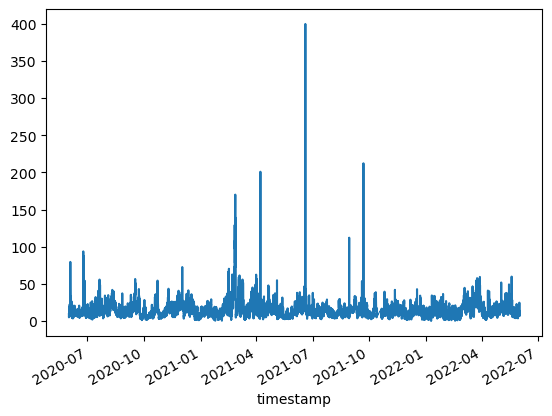

In [12]:
emissions = df['PM10']
emissions.plot()

In [13]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [14]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(emissions, WINDOW_SIZE)
X1.shape, y1.shape

((5827, 5, 1), (5827,))

In [15]:
X_train1, y_train1 = X1[:4000], y1[:4000]
X_val1, y_val1 = X1[4000:4800], y1[4000:4800]
X_test1, y_test1 = X1[4800:], y1[4800:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((4000, 5, 1), (4000,), (800, 5, 1), (800,), (1027, 5, 1), (1027,))

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [19]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [20]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
121/125 [============================>.] - ETA: 0s - loss: 256.1839 - root_mean_squared_error: 16.0057

125/125 [==============================] - 22s 141ms/step - loss: 254.6886 - root_mean_squared_error: 15.9590 - val_loss: 238.3633 - val_root_mean_squared_error: 15.4390
Epoch 2/10
116/125 [==========================>...] - ETA: 0s - loss: 196.2001 - root_mean_squared_error: 14.0071

125/125 [==============================] - 13s 105ms/step - loss: 193.2422 - root_mean_squared_error: 13.9012 - val_loss: 172.1383 - val_root_mean_squared_error: 13.1201
Epoch 3/10
116/125 [==========================>...] - ETA: 0s - loss: 135.1630 - root_mean_squared_error: 11.6260

125/125 [==============================] - 15s 124ms/step - loss: 134.1337 - root_mean_squared_error: 11.5816 - val_loss: 122.2984 - val_root_mean_squared_error: 11.0589
Epoch 4/10
124/125 [============================>.] - ETA: 0s - loss: 100.8133 - root_mean_squared_error: 10.0406

125/125 [==============================] - 18s 143ms/step - loss: 100.7765 - root_mean_squared_error: 10.0388 - val_loss: 99.8970 - val_root_mean_squared_error: 9.9948
Epoch 5/10
124/125 [============================>.] - ETA: 0s - loss: 86.5703 - root_mean_squared_error: 9.3043

125/125 [==============================] - 16s 126ms/step - loss: 86.8760 - root_mean_squared_error: 9.3207 - val_loss: 89.6850 - val_root_mean_squared_error: 9.4702
Epoch 6/10
124/125 [============================>.] - ETA: 0s - loss: 79.9897 - root_mean_squared_error: 8.9437

125/125 [==============================] - 20s 163ms/step - loss: 79.5814 - root_mean_squared_error: 8.9208 - val_loss: 82.6067 - val_root_mean_squared_error: 9.0888
Epoch 7/10
119/125 [===========================>..] - ETA: 0s - loss: 74.5821 - root_mean_squared_error: 8.6361

125/125 [==============================] - 17s 133ms/step - loss: 73.6681 - root_mean_squared_error: 8.5830 - val_loss: 75.9647 - val_root_mean_squared_error: 8.7158
Epoch 8/10
122/125 [============================>.] - ETA: 0s - loss: 68.3043 - root_mean_squared_error: 8.2646

125/125 [==============================] - 17s 138ms/step - loss: 67.8886 - root_mean_squared_error: 8.2395 - val_loss: 70.3923 - val_root_mean_squared_error: 8.3900
Epoch 9/10
122/125 [============================>.] - ETA: 0s - loss: 62.4827 - root_mean_squared_error: 7.9046

125/125 [==============================] - 17s 140ms/step - loss: 62.7549 - root_mean_squared_error: 7.9218 - val_loss: 64.8969 - val_root_mean_squared_error: 8.0559
Epoch 10/10
118/125 [===========================>..] - ETA: 0s - loss: 59.1280 - root_mean_squared_error: 7.6895

125/125 [==============================] - 22s 176ms/step - loss: 58.7959 - root_mean_squared_error: 7.6678 - val_loss: 61.1792 - val_root_mean_squared_error: 7.8217


In [21]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [22]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

125/125 [==============================] - 2s 6ms/step


,Train Predictions,Actuals
0,13.622010,11.6
1,12.852242,11.3
2,12.448582,14.6
3,14.167357,19.6
4,16.603041,23.2
...,...,...
3995,16.614370,17.7
3996,16.728550,17.9
3997,16.839226,17.8
3998,16.841763,13.4


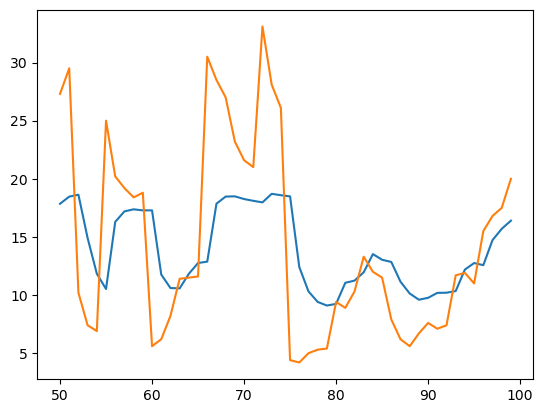

In [23]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [24]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

25/25 [==============================] - 0s 8ms/step


,Val Predictions,Actuals
0,14.263607,19.2
1,16.511623,17.4
2,16.495144,17.5
3,16.678539,29.1
4,18.428648,30.4
...,...,...
795,16.460543,16.3
796,16.187681,10.4
797,13.122576,9.6
798,12.028946,10.5


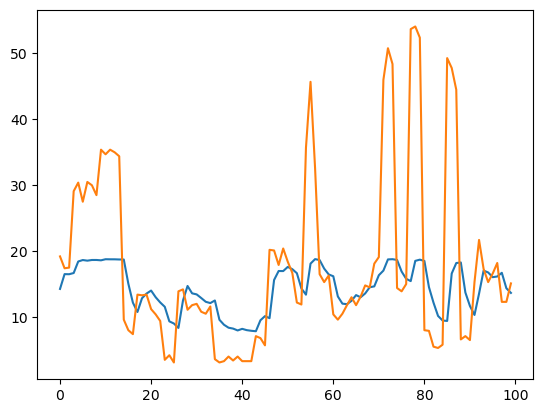

In [25]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [26]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

33/33 [==============================] - 1s 4ms/step


,Test Predictions,Actuals
0,12.458536,13.0
1,13.327362,11.8
2,12.998719,13.1
3,13.579942,14.8
4,14.517666,14.5
...,...,...
1022,11.349430,10.9
1023,11.990904,10.8
1024,12.349892,7.7
1025,11.161692,7.6


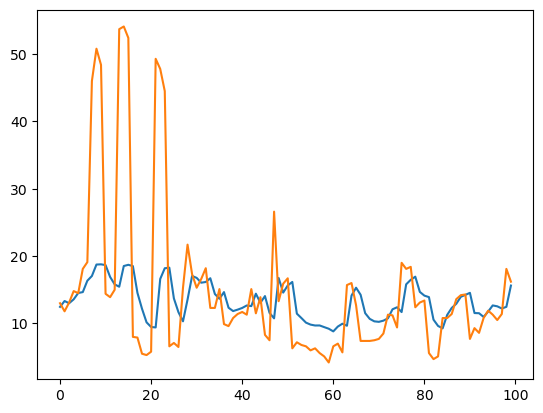

In [27]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

## Convolutional Neural Network

In [28]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [29]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [30]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp2])

Epoch 1/10
117/125 [===========================>..] - ETA: 0s - loss: 189.3554 - root_mean_squared_error: 13.7606

125/125 [==============================] - 5s 34ms/step - loss: 183.3951 - root_mean_squared_error: 13.5423 - val_loss: 91.6827 - val_root_mean_squared_error: 9.5751
Epoch 2/10
121/125 [============================>.] - ETA: 0s - loss: 75.1201 - root_mean_squared_error: 8.6672

125/125 [==============================] - 2s 17ms/step - loss: 74.9463 - root_mean_squared_error: 8.6572 - val_loss: 68.0379 - val_root_mean_squared_error: 8.2485
Epoch 3/10
118/125 [===========================>..] - ETA: 0s - loss: 59.0765 - root_mean_squared_error: 7.6861

125/125 [==============================] - 3s 24ms/step - loss: 59.4301 - root_mean_squared_error: 7.7091 - val_loss: 56.2023 - val_root_mean_squared_error: 7.4968
Epoch 4/10
125/125 [==============================] - ETA: 0s - loss: 50.3884 - root_mean_squared_error: 7.0985

125/125 [==============================] - 3s 21ms/step - loss: 50.3884 - root_mean_squared_error: 7.0985 - val_loss: 49.1613 - val_root_mean_squared_error: 7.0115
Epoch 5/10
125/125 [==============================] - ETA: 0s - loss: 44.9420 - root_mean_squared_error: 6.7039

125/125 [==============================] - 3s 26ms/step - loss: 44.9420 - root_mean_squared_error: 6.7039 - val_loss: 45.0698 - val_root_mean_squared_error: 6.7134
Epoch 6/10
107/125 [========================>.....] - ETA: 0s - loss: 41.5436 - root_mean_squared_error: 6.4454

125/125 [==============================] - 3s 24ms/step - loss: 41.7826 - root_mean_squared_error: 6.4639 - val_loss: 43.0783 - val_root_mean_squared_error: 6.5634
Epoch 7/10
124/125 [============================>.] - ETA: 0s - loss: 40.0119 - root_mean_squared_error: 6.3255

125/125 [==============================] - 3s 24ms/step - loss: 40.0868 - root_mean_squared_error: 6.3314 - val_loss: 41.3868 - val_root_mean_squared_error: 6.4333
Epoch 8/10
111/125 [=========================>....] - ETA: 0s - loss: 37.5211 - root_mean_squared_error: 6.1254

125/125 [==============================] - 3s 20ms/step - loss: 39.0336 - root_mean_squared_error: 6.2477 - val_loss: 40.5175 - val_root_mean_squared_error: 6.3653
Epoch 9/10
114/125 [==========================>...] - ETA: 0s - loss: 39.0350 - root_mean_squared_error: 6.2478

125/125 [==============================] - 3s 26ms/step - loss: 38.3272 - root_mean_squared_error: 6.1909 - val_loss: 39.9356 - val_root_mean_squared_error: 6.3195
Epoch 10/10
122/125 [============================>.] - ETA: 0s - loss: 38.2703 - root_mean_squared_error: 6.1863

125/125 [==============================] - 3s 21ms/step - loss: 37.9420 - root_mean_squared_error: 6.1597 - val_loss: 39.5050 - val_root_mean_squared_error: 6.2853


## GRU (Gated Recurrent Unit)

In [31]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [32]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [33]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp3])

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 281.2291 - root_mean_squared_error: 16.7699

125/125 [==============================] - 18s 118ms/step - loss: 281.2291 - root_mean_squared_error: 16.7699 - val_loss: 264.4203 - val_root_mean_squared_error: 16.2610
Epoch 2/10
122/125 [============================>.] - ETA: 0s - loss: 227.0378 - root_mean_squared_error: 15.0678

125/125 [==============================] - 12s 100ms/step - loss: 226.7217 - root_mean_squared_error: 15.0573 - val_loss: 214.4881 - val_root_mean_squared_error: 14.6454
Epoch 3/10
113/125 [==========================>...] - ETA: 0s - loss: 163.7390 - root_mean_squared_error: 12.7961

125/125 [==============================] - 11s 91ms/step - loss: 160.4006 - root_mean_squared_error: 12.6649 - val_loss: 140.1203 - val_root_mean_squared_error: 11.8372
Epoch 4/10
119/125 [===========================>..] - ETA: 0s - loss: 113.9864 - root_mean_squared_error: 10.6764

125/125 [==============================] - 11s 91ms/step - loss: 112.5770 - root_mean_squared_error: 10.6102 - val_loss: 108.2469 - val_root_mean_squared_error: 10.4042
Epoch 5/10
123/125 [============================>.] - ETA: 0s - loss: 90.7656 - root_mean_squared_error: 9.5271

125/125 [==============================] - 11s 92ms/step - loss: 90.7137 - root_mean_squared_error: 9.5244 - val_loss: 90.7175 - val_root_mean_squared_error: 9.5246
Epoch 6/10
117/125 [===========================>..] - ETA: 0s - loss: 78.6619 - root_mean_squared_error: 8.8692

125/125 [==============================] - 12s 95ms/step - loss: 77.6429 - root_mean_squared_error: 8.8115 - val_loss: 78.6238 - val_root_mean_squared_error: 8.8670
Epoch 7/10
123/125 [============================>.] - ETA: 0s - loss: 68.1311 - root_mean_squared_error: 8.2542

125/125 [==============================] - 13s 102ms/step - loss: 68.6744 - root_mean_squared_error: 8.2870 - val_loss: 70.5856 - val_root_mean_squared_error: 8.4015
Epoch 8/10
125/125 [==============================] - ETA: 0s - loss: 62.6466 - root_mean_squared_error: 7.9150

125/125 [==============================] - 13s 102ms/step - loss: 62.6466 - root_mean_squared_error: 7.9150 - val_loss: 65.0731 - val_root_mean_squared_error: 8.0668
Epoch 9/10
122/125 [============================>.] - ETA: 0s - loss: 58.8106 - root_mean_squared_error: 7.6688

125/125 [==============================] - 12s 96ms/step - loss: 58.4406 - root_mean_squared_error: 7.6446 - val_loss: 60.7980 - val_root_mean_squared_error: 7.7973
Epoch 10/10
111/125 [=========================>....] - ETA: 0s - loss: 54.2419 - root_mean_squared_error: 7.3649

125/125 [==============================] - 12s 95ms/step - loss: 54.9930 - root_mean_squared_error: 7.4157 - val_loss: 57.2446 - val_root_mean_squared_error: 7.5660


# Multivariate Time Series Forecasting (LSTM) for one target

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

## Preprocessing

In [10]:
multi_df = pred_data.copy()
multi_df.index = pd.to_datetime(multi_df['timestamp'], format='%Y-%m-%d %H:%M:%S')
multi_df['Seconds'] = multi_df.index.map(pd.Timestamp.timestamp)
multi_df

,timestamp,east inbound,north inbound,south inbound,west inbound,east outbound,north outbound,south outbound,west outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],PM10,"PM2,5",NO2,Seconds
timestamp,,,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,2020-06-01 00:00:00,153.0,232.0,224.0,275.0,28.0,206.2,185.0,1346.31,1021.0,72.75,13.10,0.60,96.0,9.25,4.75,9.70,1.590970e+09
2020-06-01 01:00:00,2020-06-01 01:00:00,87.0,154.4,142.0,54.0,15.0,125.4,116.0,406.90,1022.0,81.75,10.75,0.40,112.0,5.65,3.25,10.05,1.590973e+09
2020-06-01 02:00:00,2020-06-01 02:00:00,56.0,84.8,83.0,25.0,16.0,52.0,68.0,243.41,1022.0,93.05,9.35,0.45,76.5,5.05,3.05,11.40,1.590977e+09
2020-06-01 03:00:00,2020-06-01 03:00:00,39.0,52.6,43.0,15.0,3.0,53.4,42.0,272.47,1022.0,96.55,8.40,0.55,71.5,6.25,3.35,11.10,1.590980e+09
2020-06-01 04:00:00,2020-06-01 04:00:00,12.0,72.5,50.0,11.0,4.0,38.4,33.0,413.96,1022.0,98.55,7.80,0.40,111.5,6.00,3.35,9.65,1.590984e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01 20:00:00,2022-06-01 20:00:00,90.0,901.3,904.0,589.0,393.0,754.2,712.0,1255.15,1014.0,41.10,17.95,2.15,326.0,6.90,3.20,15.80,1.654114e+09
2022-06-01 21:00:00,2022-06-01 21:00:00,75.0,767.1,652.0,510.0,263.0,591.8,570.0,1023.02,1015.5,48.25,15.70,1.30,335.0,7.85,3.60,25.30,1.654117e+09
2022-06-01 22:00:00,2022-06-01 22:00:00,62.0,567.2,503.0,389.0,194.0,409.6,501.0,844.69,1016.0,59.55,13.30,0.75,198.0,8.35,4.00,32.30,1.654121e+09


In [12]:
day = 60*60*24
year = 365.2425*day

multi_df['Day sin'] = np.sin(multi_df['Seconds'] * (2* np.pi / day))
multi_df['Day cos'] = np.cos(multi_df['Seconds'] * (2 * np.pi / day))
multi_df['Year sin'] = np.sin(multi_df['Seconds'] * (2 * np.pi / year))
multi_df['Year cos'] = np.cos(multi_df['Seconds'] * (2 * np.pi / year))
multi_df['weekday'] = multi_df.index.day_of_week
multi_df.head()


,timestamp,east inbound,north inbound,south inbound,west inbound,east outbound,north outbound,south outbound,west outbound,Luftdruck[hPa],...,Windrichtung[Grad],PM10,"PM2,5",NO2,Seconds,Day sin,Day cos,Year sin,Year cos,weekday
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,2020-06-01 00:00:00,153.0,232.0,224.0,275.0,28.0,206.2,185.0,1346.31,1021.0,...,96.0,9.25,4.75,9.70,1.590970e+09,-9.128657e-12,1.000000,0.504602,-0.863352,0
2020-06-01 01:00:00,2020-06-01 01:00:00,87.0,154.4,142.0,54.0,15.0,125.4,116.0,406.90,1022.0,...,112.0,5.65,3.25,10.05,1.590973e+09,2.588190e-01,0.965926,0.503983,-0.863714,0
2020-06-01 02:00:00,2020-06-01 02:00:00,56.0,84.8,83.0,25.0,16.0,52.0,68.0,243.41,1022.0,...,76.5,5.05,3.05,11.40,1.590977e+09,5.000000e-01,0.866025,0.503364,-0.864075,0
2020-06-01 03:00:00,2020-06-01 03:00:00,39.0,52.6,43.0,15.0,3.0,53.4,42.0,272.47,1022.0,...,71.5,6.25,3.35,11.10,1.590980e+09,7.071068e-01,0.707107,0.502744,-0.864435,0
2020-06-01 04:00:00,2020-06-01 04:00:00,12.0,72.5,50.0,11.0,4.0,38.4,33.0,413.96,1022.0,...,111.5,6.00,3.35,9.65,1.590984e+09,8.660254e-01,0.500000,0.502125,-0.864795,0


In [13]:
#move target to be first column
column_to_move = multi_df.pop('PM10')
multi_df.insert(0, 'PM10', column_to_move)
multi_df

,PM10,timestamp,inbound,outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],"PM2,5",NO2,Seconds,Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,9.25,2020-06-01 00:00:00,965.0,7038.0,1021.0,72.75,13.10,0.60,96.0,4.75,9.70,1.590970e+09,-9.128657e-12,1.000000,0.504602,-0.863352
2020-06-01 01:00:00,5.65,2020-06-01 01:00:00,486.0,3824.0,1022.0,81.75,10.75,0.40,112.0,3.25,10.05,1.590973e+09,2.588190e-01,0.965926,0.503983,-0.863714
2020-06-01 02:00:00,5.05,2020-06-01 02:00:00,283.0,2062.0,1022.0,93.05,9.35,0.45,76.5,3.05,11.40,1.590977e+09,5.000000e-01,0.866025,0.503364,-0.864075
2020-06-01 03:00:00,6.25,2020-06-01 03:00:00,164.0,1660.0,1022.0,96.55,8.40,0.55,71.5,3.35,11.10,1.590980e+09,7.071068e-01,0.707107,0.502744,-0.864435
2020-06-01 04:00:00,6.00,2020-06-01 04:00:00,159.0,1836.0,1022.0,98.55,7.80,0.40,111.5,3.35,9.65,1.590984e+09,8.660254e-01,0.500000,0.502125,-0.864795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01 20:00:00,6.90,2022-06-01 20:00:00,2739.0,20770.0,1014.0,41.10,17.95,2.15,326.0,3.20,15.80,1.654114e+09,-8.660254e-01,0.500000,0.499419,-0.866360
2022-06-01 21:00:00,7.85,2022-06-01 21:00:00,2248.0,15870.0,1015.5,48.25,15.70,1.30,335.0,3.60,25.30,1.654117e+09,-7.071068e-01,0.707107,0.498798,-0.866718
2022-06-01 22:00:00,8.35,2022-06-01 22:00:00,1703.0,12972.0,1016.0,59.55,13.30,0.75,198.0,4.00,32.30,1.654121e+09,-5.000000e-01,0.866025,0.498177,-0.867075


In [16]:
#drop unwanted columns
multi_df = multi_df.drop(columns = ['timestamp', 'Seconds'])

In [17]:
#replace Nans with mean
multi_df = multi_df.fillna(multi_df.mean())

In [18]:
multi_df

,east inbound,north inbound,south inbound,west inbound,east outbound,north outbound,south outbound,west outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],...,Windgeschwindigkeit[m/s],Windrichtung[Grad],PM10,"PM2,5",NO2,Day sin,Day cos,Year sin,Year cos,weekday
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,153.0,232.0,224.0,275.0,28.0,206.2,185.0,1346.31,1021.0,72.75,...,0.60,96.0,9.25,4.75,9.70,-9.128657e-12,1.000000,0.504602,-0.863352,0
2020-06-01 01:00:00,87.0,154.4,142.0,54.0,15.0,125.4,116.0,406.90,1022.0,81.75,...,0.40,112.0,5.65,3.25,10.05,2.588190e-01,0.965926,0.503983,-0.863714,0
2020-06-01 02:00:00,56.0,84.8,83.0,25.0,16.0,52.0,68.0,243.41,1022.0,93.05,...,0.45,76.5,5.05,3.05,11.40,5.000000e-01,0.866025,0.503364,-0.864075,0
2020-06-01 03:00:00,39.0,52.6,43.0,15.0,3.0,53.4,42.0,272.47,1022.0,96.55,...,0.55,71.5,6.25,3.35,11.10,7.071068e-01,0.707107,0.502744,-0.864435,0
2020-06-01 04:00:00,12.0,72.5,50.0,11.0,4.0,38.4,33.0,413.96,1022.0,98.55,...,0.40,111.5,6.00,3.35,9.65,8.660254e-01,0.500000,0.502125,-0.864795,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01 20:00:00,90.0,901.3,904.0,589.0,393.0,754.2,712.0,1255.15,1014.0,41.10,...,2.15,326.0,6.90,3.20,15.80,-8.660254e-01,0.500000,0.499419,-0.866360,2
2022-06-01 21:00:00,75.0,767.1,652.0,510.0,263.0,591.8,570.0,1023.02,1015.5,48.25,...,1.30,335.0,7.85,3.60,25.30,-7.071068e-01,0.707107,0.498798,-0.866718,2
2022-06-01 22:00:00,62.0,567.2,503.0,389.0,194.0,409.6,501.0,844.69,1016.0,59.55,...,0.75,198.0,8.35,4.00,32.30,-5.000000e-01,0.866025,0.498177,-0.867075,2


In [19]:
multi_df.describe()

,east inbound,north inbound,south inbound,west inbound,east outbound,north outbound,south outbound,west outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],...,Windgeschwindigkeit[m/s],Windrichtung[Grad],PM10,"PM2,5",NO2,Day sin,Day cos,Year sin,Year cos,weekday
count,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,...,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,1.754100e+04,1.754100e+04,17541.000000,17541.000000,17541.000000
mean,637.070520,801.798704,838.763448,453.455789,365.108204,605.522388,671.412006,1148.101487,1017.280325,77.321671,...,1.211699,149.424409,14.228799,9.215885,27.321615,-2.749911e-05,-1.518672e-04,0.000366,-0.000728,2.991107
std,489.928779,555.434910,600.370981,303.501293,313.133069,460.708475,511.746900,859.736520,8.921590,20.474889,...,0.611074,87.290741,10.375028,6.079822,15.164261,7.071618e-01,7.070920e-01,0.706934,0.707320,2.000379
min,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,980.000000,24.250000,...,0.350000,1.000000,0.500000,0.500000,2.150000,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,0.000000
25%,145.000000,213.600000,200.000000,143.000000,69.000000,153.000000,172.000000,285.760000,1012.500000,61.900000,...,0.750000,66.000000,8.250000,4.700000,16.200000,-7.071068e-01,-7.071068e-01,-0.706555,-0.708442,1.000000
50%,563.000000,803.800000,867.000000,467.000000,295.000000,508.400000,624.000000,1093.240000,1018.000000,83.050000,...,1.100000,154.000000,12.350000,7.700000,24.650000,-1.801471e-14,1.552518e-14,0.001240,-0.001566,3.000000
75%,1098.000000,1327.600000,1384.000000,737.000000,604.000000,1069.800000,1047.000000,1826.090000,1023.000000,95.600000,...,1.550000,229.000000,17.650000,12.200000,35.250000,7.071068e-01,7.071068e-01,0.706510,0.706786,5.000000
max,2017.000000,2182.600000,3054.000000,1328.000000,1673.000000,1708.200000,2750.000000,4063.250000,1041.000000,100.100000,...,5.400000,360.000000,399.500000,62.650000,156.950000,1.000000e+00,1.000000e+00,1.000000,1.000000,6.000000


In [69]:
#standardize

scaler = MinMaxScaler(feature_range=(-1, 1))

multi_df_scaled = scaler.fit_transform(multi_df)
multi_df_scaled = pd.DataFrame(multi_df_scaled, columns=multi_df.columns, index=multi_df.index)


In [70]:
multi_df_scaled

,PM10,inbound,outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],"PM2,5",NO2,Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,,,,,,,,,
2020-06-01 00:00:00,-0.956140,-0.726963,-0.835091,0.344262,0.278840,-8.333333e-03,-0.900990,-0.470752,-0.863234,-0.902455,-9.128657e-12,1.000000,0.504602,-0.863352
2020-06-01 01:00:00,-0.974185,-0.862773,-0.910399,0.377049,0.516150,-1.062500e-01,-0.980198,-0.381616,-0.911504,-0.897933,2.588190e-01,0.965926,0.503983,-0.863714
2020-06-01 02:00:00,-0.977193,-0.920329,-0.951685,0.377049,0.814107,-1.645833e-01,-0.960396,-0.579387,-0.917940,-0.880491,5.000000e-01,0.866025,0.503364,-0.864075
2020-06-01 03:00:00,-0.971178,-0.954069,-0.961104,0.377049,0.906394,-2.041667e-01,-0.920792,-0.607242,-0.908286,-0.884367,7.071068e-01,0.707107,0.502744,-0.864435
2020-06-01 04:00:00,-0.972431,-0.955486,-0.956980,0.377049,0.959130,-2.291667e-01,-0.980198,-0.384401,-0.908286,-0.903101,8.660254e-01,0.500000,0.502125,-0.864795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01 20:00:00,-0.967920,-0.223986,-0.513332,0.114754,-0.555702,1.937500e-01,-0.287129,0.810585,-0.913113,-0.823643,-8.660254e-01,0.500000,0.499419,-0.866360
2022-06-01 21:00:00,-0.963158,-0.363198,-0.628146,0.163934,-0.367172,1.000000e-01,-0.623762,0.860724,-0.900241,-0.700904,-7.071068e-01,0.707107,0.498798,-0.866718
2022-06-01 22:00:00,-0.960652,-0.517720,-0.696049,0.180328,-0.069216,2.220446e-16,-0.841584,0.097493,-0.887369,-0.610465,-5.000000e-01,0.866025,0.498177,-0.867075


## Create tensors

In [71]:
#create X and Y
def df_to_X_y2(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    #define y
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [72]:
X2, y2 = df_to_X_y2(multi_df_scaled)
X2.shape, y2.shape

((17534, 7, 14), (17534,))

In [56]:
#split data
X2_train, y2_train = X2[:10000], y2[:10000]
X2_val, y2_val = X2[10000:13500], y2[10000:13500]
X2_test, y2_test = X2[13500:], y2[13500:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape


((10000, 7, 14), (10000,), (3500, 7, 14), (3500,), (4034, 7, 14), (4034,))

# Create model & predict

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import load_model


from sklearn.metrics import mean_squared_error as mse

In [60]:
#create SMALL model

clear_session()

model4 = Sequential()
model4.add(InputLayer((7, 14)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20224     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 20,753
Trainable params: 20,753
Non-trainable params: 0
_________________________________________________________________


In [28]:
#set up checkpoint to save best model
cp4 = ModelCheckpoint('model4/', save_best_only=True)
#compile model 
model4.compile(loss=MeanAbsoluteError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

NameError: name 'model4' is not defined

In [63]:
#create BIGGER model

# Clear the Keras session
clear_session()

# Set up checkpoint to save the best model
cp4 = ModelCheckpoint('model4/', save_best_only=True)

# Create the model
model4 = Sequential()

# Input layer
model4.add(InputLayer((7, 14)))

model4.add(LSTM(128, return_sequences=True))
model4.add(Dropout(0.2))

# Decrease the number of neurons in Dense layers and add L1-Regularization
model4.add(Dense(64, activation='relu', kernel_regularizer=l1(0.001)))
model4.add(Dense(16, activation='relu', kernel_regularizer=l1(0.001)))


model4.add(Dense(1, activation='linear'))

model4.compile(loss='mean_absolute_error', optimizer=Adagrad(learning_rate=1), metrics=[RootMeanSquaredError()])

# Display model summary
model4.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            73216     
                                                                 
 dropout (Dropout)           (None, 7, 128)            0         
                                                                 
 dense (Dense)               (None, 7, 64)             8256      
                                                                 
 dense_1 (Dense)             (None, 7, 16)             1040      
                                                                 
 dense_2 (Dense)             (None, 7, 1)              17        
                                                                 
Total params: 82,529
Trainable params: 82,529
Non-trainable params: 0
_________________________________________________________________


In [64]:
#fit model
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[cp4])

Epoch 1/10
312/313 [============================>.] - ETA: 0s - loss: 0.6712 - root_mean_squared_error: 2.6612

313/313 [==============================] - 20s 53ms/step - loss: 0.6704 - root_mean_squared_error: 2.6602 - val_loss: 0.1535 - val_root_mean_squared_error: 0.0405
Epoch 2/10
312/313 [============================>.] - ETA: 0s - loss: 0.0870 - root_mean_squared_error: 0.0622

313/313 [==============================] - 15s 49ms/step - loss: 0.0870 - root_mean_squared_error: 0.0622 - val_loss: 0.0590 - val_root_mean_squared_error: 0.0469
Epoch 3/10
313/313 [==============================] - 3s 8ms/step - loss: 0.0532 - root_mean_squared_error: 0.0617 - val_loss: 0.0658 - val_root_mean_squared_error: 0.0574
Epoch 4/10
309/313 [============================>.] - ETA: 0s - loss: 0.0505 - root_mean_squared_error: 0.0613

313/313 [==============================] - 16s 50ms/step - loss: 0.0505 - root_mean_squared_error: 0.0613 - val_loss: 0.0383 - val_root_mean_squared_error: 0.0363
Epoch 5/10
313/313 [==============================] - 3s 8ms/step - loss: 0.0492 - root_mean_squared_error: 0.0614 - val_loss: 0.0539 - val_root_mean_squared_error: 0.0483
Epoch 6/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0488 - root_mean_squared_error: 0.0613 - val_loss: 0.0417 - val_root_mean_squared_error: 0.0381
Epoch 7/10
313/313 [==============================] - 3s 8ms/step - loss: 0.0487 - root_mean_squared_error: 0.0614 - val_loss: 0.0414 - val_root_mean_squared_error: 0.0379
Epoch 8/10
307/313 [============================>.] - ETA: 0s - loss: 0.0483 - root_mean_squared_error: 0.0612

313/313 [==============================] - 15s 49ms/step - loss: 0.0483 - root_mean_squared_error: 0.0610 - val_loss: 0.0378 - val_root_mean_squared_error: 0.0359
Epoch 9/10
313/313 [==============================] - 2s 8ms/step - loss: 0.0480 - root_mean_squared_error: 0.0609 - val_loss: 0.0428 - val_root_mean_squared_error: 0.0433
Epoch 10/10
313/313 [==============================] - 3s 8ms/step - loss: 0.0481 - root_mean_squared_error: 0.0611 - val_loss: 0.0393 - val_root_mean_squared_error: 0.0367


In [65]:
# function to predict and plot predictions
def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

In [225]:
# predictions = model4.predict(X2_test).flatten()
# #
# df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y2_test})
# df

25/25 [==============================] - 3s 118ms/step


array([12.559116, 12.559116, 12.559116, ..., 12.559116, 12.559116,
       12.559116], dtype=float32)

In [66]:
predictions = model4.predict(X2_test).flatten()
predictions

127/127 [==============================] - 1s 3ms/step


array([-0.93164814, -0.93164814, -0.93164814, ..., -0.93164814,
       -0.93164814, -0.93164814], dtype=float32)

In [67]:
len(predictions)

28238

In [68]:
plot_predictions1(model4, X2_test, y2_test)

127/127 [==============================] - 0s 3ms/step


ValueError: All arrays must be of the same length

## Predict multiple targets

In [20]:
multi_df2 = multi_df

In [21]:
multi_df2.describe()

,east inbound,north inbound,south inbound,west inbound,east outbound,north outbound,south outbound,west outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],...,Windgeschwindigkeit[m/s],Windrichtung[Grad],PM10,"PM2,5",NO2,Day sin,Day cos,Year sin,Year cos,weekday
count,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,...,17541.000000,17541.000000,17541.000000,17541.000000,17541.000000,1.754100e+04,1.754100e+04,17541.000000,17541.000000,17541.000000
mean,637.070520,801.798704,838.763448,453.455789,365.108204,605.522388,671.412006,1148.101487,1017.280325,77.321671,...,1.211699,149.424409,14.228799,9.215885,27.321615,-2.749911e-05,-1.518672e-04,0.000366,-0.000728,2.991107
std,489.928779,555.434910,600.370981,303.501293,313.133069,460.708475,511.746900,859.736520,8.921590,20.474889,...,0.611074,87.290741,10.375028,6.079822,15.164261,7.071618e-01,7.070920e-01,0.706934,0.707320,2.000379
min,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,980.000000,24.250000,...,0.350000,1.000000,0.500000,0.500000,2.150000,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,0.000000
25%,145.000000,213.600000,200.000000,143.000000,69.000000,153.000000,172.000000,285.760000,1012.500000,61.900000,...,0.750000,66.000000,8.250000,4.700000,16.200000,-7.071068e-01,-7.071068e-01,-0.706555,-0.708442,1.000000
50%,563.000000,803.800000,867.000000,467.000000,295.000000,508.400000,624.000000,1093.240000,1018.000000,83.050000,...,1.100000,154.000000,12.350000,7.700000,24.650000,-1.801471e-14,1.552518e-14,0.001240,-0.001566,3.000000
75%,1098.000000,1327.600000,1384.000000,737.000000,604.000000,1069.800000,1047.000000,1826.090000,1023.000000,95.600000,...,1.550000,229.000000,17.650000,12.200000,35.250000,7.071068e-01,7.071068e-01,0.706510,0.706786,5.000000
max,2017.000000,2182.600000,3054.000000,1328.000000,1673.000000,1708.200000,2750.000000,4063.250000,1041.000000,100.100000,...,5.400000,360.000000,399.500000,62.650000,156.950000,1.000000e+00,1.000000e+00,1.000000,1.000000,6.000000


In [22]:

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Separate your DataFrame into features and target variable
X = multi_df2.drop(columns=["PM10", "PM2,5", "NO2"])

y = multi_df2[["PM10", "PM2,5", "NO2"]]

# Scale the features (X) and target (y) separately
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create a new DataFrame with the scaled features and target variable
X_scaled_df = pd.DataFrame(data=X_scaled, columns=X.columns, index=multi_df2.index)
y_scaled_df  = pd.DataFrame(data=y_scaled, columns=y.columns, index=multi_df2.index)
#df_scaled = y_scaled_df.merge(X_scaled_df, left_index=True, right_index=True)
#df_scaled
X_scaled_df


,east inbound,north inbound,south inbound,west inbound,east outbound,north outbound,south outbound,west outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],Day sin,Day cos,Year sin,Year cos,weekday
timestamp,,,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,0.075855,0.106295,0.073346,0.207078,0.016736,0.120712,0.067273,0.331338,0.672131,0.639420,0.495833,0.049505,0.264624,0.500000,1.000000,0.752301,0.068324,0.000000
2020-06-01 01:00:00,0.043133,0.070741,0.046496,0.040663,0.008966,0.073411,0.042182,0.100142,0.688525,0.758075,0.446875,0.009901,0.309192,0.629410,0.982963,0.751992,0.068143,0.000000
2020-06-01 02:00:00,0.027764,0.038853,0.027177,0.018825,0.009564,0.030441,0.024727,0.059905,0.688525,0.907053,0.417708,0.019802,0.210306,0.750000,0.933013,0.751682,0.067963,0.000000
2020-06-01 03:00:00,0.019336,0.024100,0.014080,0.011295,0.001793,0.031261,0.015273,0.067057,0.688525,0.953197,0.397917,0.039604,0.196379,0.853553,0.853553,0.751372,0.067782,0.000000
2020-06-01 04:00:00,0.005949,0.033217,0.016372,0.008283,0.002391,0.022480,0.012000,0.101879,0.688525,0.979565,0.385417,0.009901,0.307799,0.933013,0.750000,0.751062,0.067602,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01 20:00:00,0.044621,0.412948,0.296005,0.443524,0.234907,0.441517,0.258909,0.308903,0.557377,0.222149,0.596875,0.356436,0.905292,0.066987,0.750000,0.749710,0.066820,0.333333
2022-06-01 21:00:00,0.037184,0.351462,0.213491,0.384036,0.157203,0.346447,0.207273,0.251774,0.581967,0.316414,0.550000,0.188119,0.930362,0.146447,0.853553,0.749399,0.066641,0.333333
2022-06-01 22:00:00,0.030739,0.259874,0.164702,0.292922,0.115959,0.239785,0.182182,0.207885,0.590164,0.465392,0.500000,0.079208,0.548747,0.250000,0.933013,0.749088,0.066462,0.333333


In [72]:
#just necessary with one target 


# #move target to be first column
# column_to_move = df_scaled.pop('PM10')
# df_scaled.insert(0, 'PM10', column_to_move)
# df_scaled

,PM10,sum_vehicles,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,,,,,,
2022-08-26 07:00:00,0.394118,0.152252,0.519231,0.703540,0.859589,0.040000,0.195906,1.000000,0.370590,0.094113,0.207443
2022-08-26 07:30:00,0.488235,0.416343,0.519231,0.690265,0.866438,0.000000,0.152047,0.978612,0.308658,0.094008,0.207589
2022-08-26 08:00:00,0.578431,0.246817,0.519231,0.648968,0.893836,0.080000,0.093567,0.949184,0.250000,0.093904,0.207734
2022-08-29 07:00:00,0.147059,0.180765,0.653846,0.712389,0.613014,0.320000,0.108187,1.000000,0.370590,0.079591,0.228788
2022-08-29 07:30:00,0.160784,0.439424,0.653846,0.672566,0.643836,0.320000,0.116959,0.978612,0.308658,0.079494,0.228939
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-02 04:00:00,0.152941,0.449915,0.596154,0.966077,0.602740,0.247116,0.391703,0.949184,0.750000,0.063509,0.255594
2023-09-02 04:30:00,0.150980,0.081717,0.615385,0.966077,0.599315,0.247116,0.391703,0.978612,0.691342,0.063421,0.255750
2023-09-14 23:00:00,0.090196,0.100313,0.653846,0.936578,0.544521,0.247116,0.391703,0.377014,0.982963,0.020800,0.356840


In [23]:
#create windows
def df_to_X_y2(df, window_size=10):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    #define y
    label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1], df_as_np[i+window_size][2]]
    y.append(label)
  return np.array(X), np.array(y)

In [24]:
X5, y5 = df_to_X_y2(X_scaled_df)
X5.shape, y5.shape

((17531, 10, 18), (17531, 3))

In [25]:
#split data
X5_train, y5_train = X5[:10000], y5[:10000]
X5_val, y5_val = X5[10000:13500], y5[10000:13500]
X5_test, y5_test = X5[13500:], y5[13500:]
X5_train.shape, y5_train.shape, X5_val.shape, y5_val.shape, X5_test.shape, y5_test.shape


((10000, 10, 18),
 (10000, 3),
 (3500, 10, 18),
 (3500, 3),
 (4031, 10, 18),
 (4031, 3))

### Create model

In [29]:
#create model

# Clear the Keras session
clear_session()

# Set up checkpoint to save the best model
cp5 = ModelCheckpoint('model8/', save_best_only=True)

# Create the model
model5 = Sequential()

# Input layer
model5.add(InputLayer((10,18)))

model5.add(LSTM(512))
model5.add(Dropout(0.2))

# Decrease the number of neurons in Dense layers and add L1-Regularization
model5.add(Dense(164, activation='linear'))#, kernel_regularizer=l1(0.001)))
model5.add(Dense(24, activation='linear'))#, kernel_regularizer=l1(0.001)))


model5.add(Dense(3, activation='linear'))

#model5.compile(loss='mean_absolute_error', optimizer=Adagrad(learning_rate=1), metrics=[RootMeanSquaredError()])
model5.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001), metrics=['mean_squared_error'])

# Display model summary
model5.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1087488   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 164)               84132     
                                                                 
 dense_1 (Dense)             (None, 24)                3960      
                                                                 
 dense_2 (Dense)             (None, 3)                 75        
                                                                 
Total params: 1,175,655
Trainable params: 1,175,655
Non-trainable params: 0
_________________________________________________________________


In [37]:
#fit model
model5.fit(X5_train, y5_train, validation_data=(X5_val, y5_val), epochs=130, callbacks=[cp5])

Epoch 1/130
313/313 [==============================] - 16s 52ms/step - loss: 0.0263 - mean_squared_error: 0.0014 - val_loss: 0.0336 - val_mean_squared_error: 0.0031
Epoch 2/130
313/313 [==============================] - ETA: 0s - loss: 0.0262 - mean_squared_error: 0.0014

313/313 [==============================] - 29s 93ms/step - loss: 0.0262 - mean_squared_error: 0.0014 - val_loss: 0.0316 - val_mean_squared_error: 0.0030
Epoch 3/130
313/313 [==============================] - 26s 84ms/step - loss: 0.0254 - mean_squared_error: 0.0013 - val_loss: 0.0363 - val_mean_squared_error: 0.0034
Epoch 4/130
313/313 [==============================] - 19s 61ms/step - loss: 0.0255 - mean_squared_error: 0.0013 - val_loss: 0.0338 - val_mean_squared_error: 0.0031
Epoch 5/130
313/313 [==============================] - 17s 55ms/step - loss: 0.0251 - mean_squared_error: 0.0013 - val_loss: 0.0329 - val_mean_squared_error: 0.0031
Epoch 6/130
313/313 [==============================] - 23s 75ms/step - loss: 0.0247 - mean_squared_error: 0.0013 - val_loss: 0.0327 - val_mean_squared_error: 0.0031
Epoch 7/130
313/313 [==============================] - 25s 78ms/step - loss: 0.0242 - mean_squared_error: 0.0012 - val_loss: 0.0348 - val_mean_squared_error: 0.0033
Epoch 8/130
313/313 [=

313/313 [==============================] - 35s 111ms/step - loss: 0.0227 - mean_squared_error: 0.0011 - val_loss: 0.0306 - val_mean_squared_error: 0.0029
Epoch 20/130
312/313 [============================>.] - ETA: 0s - loss: 0.0226 - mean_squared_error: 0.0011

313/313 [==============================] - 32s 102ms/step - loss: 0.0225 - mean_squared_error: 0.0011 - val_loss: 0.0305 - val_mean_squared_error: 0.0029
Epoch 21/130
313/313 [==============================] - 19s 62ms/step - loss: 0.0226 - mean_squared_error: 0.0011 - val_loss: 0.0329 - val_mean_squared_error: 0.0032
Epoch 22/130
313/313 [==============================] - 20s 65ms/step - loss: 0.0223 - mean_squared_error: 0.0011 - val_loss: 0.0363 - val_mean_squared_error: 0.0035
Epoch 23/130
313/313 [==============================] - ETA: 0s - loss: 0.0222 - mean_squared_error: 0.0011

313/313 [==============================] - 34s 109ms/step - loss: 0.0222 - mean_squared_error: 0.0011 - val_loss: 0.0305 - val_mean_squared_error: 0.0029
Epoch 24/130
313/313 [==============================] - 23s 74ms/step - loss: 0.0225 - mean_squared_error: 0.0011 - val_loss: 0.0374 - val_mean_squared_error: 0.0037
Epoch 25/130
313/313 [==============================] - 20s 64ms/step - loss: 0.0219 - mean_squared_error: 0.0011 - val_loss: 0.0322 - val_mean_squared_error: 0.0031
Epoch 26/130
313/313 [==============================] - 17s 53ms/step - loss: 0.0217 - mean_squared_error: 0.0010 - val_loss: 0.0331 - val_mean_squared_error: 0.0032
Epoch 27/130
313/313 [==============================] - 27s 86ms/step - loss: 0.0216 - mean_squared_error: 0.0010 - val_loss: 0.0342 - val_mean_squared_error: 0.0033
Epoch 28/130
313/313 [==============================] - 18s 58ms/step - loss: 0.0216 - mean_squared_error: 0.0010 - val_loss: 0.0311 - val_mean_squared_error: 0.0030
Epoch 29/130
313

In [33]:
#load model
#model5 = load_model('model5/')
model6 = load_model('model8/')

In [144]:
# prdiction for one target value

def plot_predictions5(model, X, y, start=0, end=400):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

In [34]:
#prediction for multiple target values

def plot_predictions2(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  pm10_preds, pm25_preds, no2_preds = predictions[:, 0], predictions[:, 1], predictions[:, 2]
  pm10_actuals, pm25_actuals, no2_actuals = y[:, 0], y[:, 1], y[:, 2]
  df_pred = pd.DataFrame(data={'PM 10 Predictions': pm10_preds,
                          'PM 10 Actuals':pm10_actuals,
                          'PM 2,5 Predictions': pm25_preds,
                          'PM 2,5 Actuals': pm25_actuals,
                          'NO2 Predictions': no2_preds,
                          'NO2 Actuals': no2_actuals
                          })
  fig, axes = plt.subplots(2,2, figsize=(12, 8))

  # Plot PM10 Predictions and Actuals
  axes[0, 0].plot(df_pred['PM 10 Predictions'][start:end], label='PM10 Predictions')
  axes[0, 0].plot(df_pred['PM 10 Actuals'][start:end], label='PM10 Actuals')
  axes[0, 0].legend()

  # Plot PM2.5 Predictions and Actuals
  axes[0, 1].plot(df_pred['PM 2,5 Predictions'][start:end], label='PM2.5 Predictions')
  axes[0, 1].plot(df_pred['PM 2,5 Actuals'][start:end], label='PM2.5 Actuals')
  axes[0, 1].legend()

  # Plot NO2 Predictions and Actuals
  axes[1, 0].plot(df_pred['NO2 Predictions'][start:end], label='NO2 Predictions')
  axes[1, 0].plot(df_pred['NO2 Actuals'][start:end], label='NO2 Actuals')
  axes[1, 0].legend()

  # Remove the empty subplot
  fig.delaxes(axes[1, 1])

  plt.tight_layout()
  
  plt.savefig('plot_predictions.png')
  plt.show()
  return show(df_pred[start:end])

In [35]:
model6.evaluate(X5_test, y5_test)

126/126 [==============================] - 2s 12ms/step - loss: 0.0311 - mean_squared_error: 0.0020


[0.031079599633812904, 0.0019816311541944742]

126/126 [==============================] - 2s 13ms/step


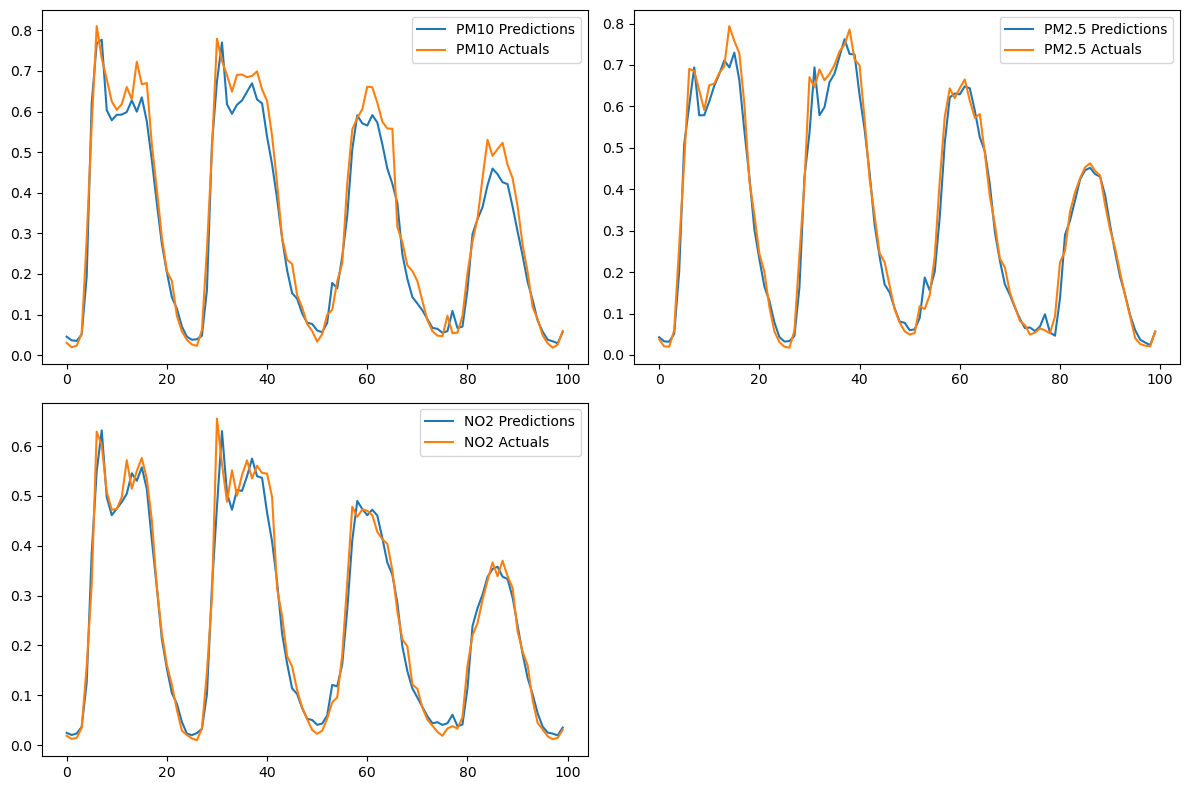

In [36]:
plot_predictions2(model6, X5_test, y5_test)

### Invert Prediction Values
Not working for multitarget predictions

In [ ]:
# Reshape 'Predictions' and 'Actuals' to have one feature
predictions = df['Predictions'].values.reshape(-1, 1)
actuals = df['Actuals'].values.reshape(-1, 1)


In [73]:
predictions_inverted = scaler_y.inverse_transform(predictions)
actuals_inverted = scaler_y.inverse_transform(actuals)

In [75]:
df_inverted = pd.DataFrame({
    'Predictions': predictions_inverted.flatten(),
    'Actuals': actuals_inverted.flatten()
})
df_inverted

,Predictions,Actuals
0,17.151331,11.6
1,16.885956,11.0
2,15.532189,6.2
3,13.222870,7.8
4,13.280419,6.9
5,11.861265,8.1
6,12.661733,8.6
7,13.150102,8.4
8,12.224852,6.6
9,11.035548,8.0


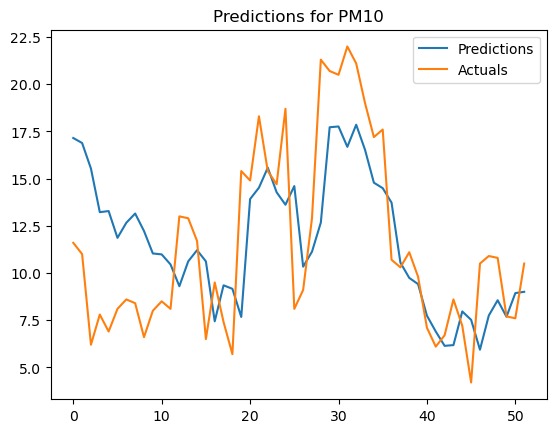

In [83]:
plt.plot(df_inverted['Predictions'])
plt.plot(df_inverted['Actuals'])
plt.title('Predictions for PM10')
plt.legend(['Predictions', 'Actuals'])
plt.savefig('predicts.png')


In [80]:
df_inverted.describe()

,Predictions,Actuals
count,52.000000,52.000000
mean,11.615685,11.407692
std,3.424712,4.813903
min,5.937706,4.200000
25%,8.986202,7.775000
50%,11.081864,10.400000
75%,14.330673,14.750000
max,17.854692,22.000000


# NO2 Predictions

In [17]:

traffic = pd.read_csv('traffic.csv')
traffic_gr= traffic.groupby(['roundedTimestamp', 'Bezeichnung']).sum()
traffic_gr = traffic_gr.reset_index()
traffic_gr
sum_vehicles_list = []

for i, row in traffic_gr.iterrows():
    sum_vehicles = row[2:67].sum()
    sum_vehicles_list.append(sum_vehicles)

traffic_gr['SumVehicles'] = sum_vehicles_list
data = {'intersection' : traffic_gr['Bezeichnung'], 'timestamp' : traffic_gr['roundedTimestamp'], 'sum_vehicles': sum_vehicles_list}
traffic_sum = pd.DataFrame(data = data)
traffic_sum
traffic_sum_total = traffic_sum.groupby('timestamp')['sum_vehicles'].sum()
traffic_sum_total = pd.DataFrame(traffic_sum_total).reset_index()
traffic_sum_total
pred_data1 = traffic_sum_total.merge(weather, how='left', left_on= 'timestamp', right_on='datetime').merge(emissions[['PM10', 'PM2,5', 'NO2', 'datetime']], how='left', left_on= 'timestamp', right_on='datetime' )
pred_data1.drop(columns=['datetime_y', 'datetime_x'], inplace = True)
show(pred_data1)

df_sum = pred_data1.copy()
df_sum.index = pd.to_datetime(df_sum['timestamp'], format='%Y-%m-%d %H:%M:%S')
df_sum[:26]
df_sum['Seconds'] = df_sum.index.map(pd.Timestamp.timestamp)
df_sum
day = 60*60*24
year = 365.2425*day

df_sum['Day sin'] = np.sin(df_sum['Seconds'] * (2* np.pi / day))
df_sum['Day cos'] = np.cos(df_sum['Seconds'] * (2 * np.pi / day))
df_sum['Year sin'] = np.sin(df_sum['Seconds'] * (2 * np.pi / year))
df_sum['Year cos'] = np.cos(df_sum['Seconds'] * (2 * np.pi / year))
df_sum.head()

#drop unwanted columns
df_sum = df_sum.drop(columns = ['timestamp', 'Seconds'])
df_sum = df_sum.fillna(df_sum.mean())
df_sum


scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Separate your DataFrame into features and target variable
X = df_sum.drop(columns=["NO2"])

y = df_sum[["NO2"]]

# Scale the features (X) and target (y) separately
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create a new DataFrame with the scaled features and target variable
df_scaled = pd.DataFrame(data=X_scaled, columns=X.columns, index=df_sum.index)
df_scaled['NO2'] = y
print(df_scaled)

# #move target to be first column
column_to_move = df_scaled.pop('PM10')
df_scaled.insert(0, 'PM10', column_to_move)
df_scaled

def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    #define y
    label = [df_as_np[i+window_size]]
    y.append(label)
  return np.array(X), np.array(y)
X5, y5 = df_to_X_y2(df_scaled)
X5.shape, y5.shape

#split data
X5_train, y5_train = X5[:300], y5[:300]
X5_val, y5_val = X5[300:350], y5[300:350]
X5_test, y5_test = X5[350:], y5[350:]
X5_train.shape, y5_train.shape, X5_val.shape, y5_val.shape, X5_test.shape, y5_test.shape

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adagrad, Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.backend import clear_session

# Clear the Keras session
clear_session()

# Set up checkpoint to save the best model
cp5 = ModelCheckpoint('model_no2/', save_best_only=True)

# Create the model
model_no2 = Sequential()

# Input layer
model_no2.add(InputLayer((6,13)))

model_no2.add(LSTM(64))
model_no2.add(Dropout(0.2))

# Decrease the number of neurons in Dense layers and add L1-Regularization
model_no2.add(Dense(64, activation='relu'))#, kernel_regularizer=l1(0.001)))
model_no2.add(Dense(16, activation='relu'))#, kernel_regularizer=l1(0.001)))


model_no2.add(Dense(1, activation='linear'))

#model5.compile(loss='mean_absolute_error', optimizer=Adagrad(learning_rate=1), metrics=[RootMeanSquaredError()])
model_no2.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001), metrics=['mean_squared_error'])

# Display model summary
model_no2.summary()

#fit model
model_no2.fit(X5_train, y5_train, validation_data=(X5_val, y5_val), epochs=20, callbacks=[cp5])
from tensorflow.keras.models import load_model
model_no2 = load_model('model_no2/')
# prdiction for one target value


from sklearn.metrics import mean_squared_error as mse

def plot_predictions_no2(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y_scaled})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)


model_no2.evaluate(X5_test, y5_test)
plot_predictions_no2(model_no2, X5_test, y5_test)

### Invert Prediction Values
# Reshape 'Predictions' and 'Actuals' to have one feature
predictions = df['Predictions'].values.reshape(-1, 1)
actuals = df['Actuals'].values.reshape(-1, 1)

predictions_inverted = scaler_y.inverse_transform(predictions)
actuals_inverted = scaler_y.inverse_transform(actuals)
df_inverted = pd.DataFrame({
    'Predictions': predictions_inverted.flatten(),
    'Actuals': actuals_inverted.flatten()
})
df_inverted
plt.plot(df_inverted['Predictions'])
plt.plot(df_inverted['Actuals'])
plt.title('Predictions for NO2')
plt.legend(['Predictions', 'Actuals'])
plt.savefig('predicts.png')

df_inverted.describe()

                     sum_vehicles  Luftdruck[hPa]  \
timestamp                                           
2022-08-26 07:00:00      0.152252        0.519231   
2022-08-26 07:30:00      0.416343        0.519231   
2022-08-26 08:00:00      0.246817        0.519231   
2022-08-29 07:00:00      0.180765        0.653846   
2022-08-29 07:30:00      0.439424        0.653846   
...                           ...             ...   
2023-09-02 04:00:00      0.449915        0.596154   
2023-09-02 04:30:00      0.081717        0.615385   
2023-09-14 23:00:00      0.100313        0.653846   
2023-09-14 23:30:00      0.248771        0.653846   
2023-09-15 00:00:00      0.083297        0.538462   

                     Relative Luftfeuchtigkeit[%]  Temperatur[°C]  \
timestamp                                                           
2022-08-26 07:00:00                      0.703540        0.859589   
2022-08-26 07:30:00                      0.690265        0.866438   
2022-08-26 08:00:00               

10/10 [==============================] - 19s 2s/step - loss: 2.1977 - mean_squared_error: 61.4838 - val_loss: 1.2620 - val_mean_squared_error: 14.0242
Epoch 2/20
 6/10 [=================>............] - ETA: 0s - loss: 2.1278 - mean_squared_error: 58.5901

10/10 [==============================] - 13s 1s/step - loss: 2.1483 - mean_squared_error: 60.7950 - val_loss: 1.2542 - val_mean_squared_error: 14.3387
Epoch 3/20
 1/10 [==>...........................] - ETA: 0s - loss: 2.3103 - mean_squared_error: 71.9694

10/10 [==============================] - 13s 1s/step - loss: 2.1431 - mean_squared_error: 60.3107 - val_loss: 1.2519 - val_mean_squared_error: 14.2057
Epoch 4/20
 1/10 [==>...........................] - ETA: 0s - loss: 2.0603 - mean_squared_error: 50.5106

KeyboardInterrupt: 

In [18]:
model_no2.evaluate(X5_test, y5_test)

2/2 [==============================] - 0s 13ms/step - loss: 1.2213 - mean_squared_error: 15.2011


[1.2213366031646729, 15.201141357421875]

In [20]:
y_scaled

array([[0.40705563],
       [0.54545455],
       [0.49389417],
       [0.1614654 ],
       [0.20895522],
       [0.16824966],
       [0.38941655],
       [0.37177748],
       [0.40434193],
       [0.16960651],
       [0.18453189],
       [0.17232022],
       [0.44776119],
       [0.37042062],
       [0.40976934],
       [0.10719132],
       [0.12347354],
       [0.13432836],
       [0.1614654 ],
       [0.16824966],
       [0.55088195],
       [0.59972863],
       [0.53052917],
       [0.31886024],
       [0.27815468],
       [0.30664858],
       [0.26322931],
       [0.19131615],
       [0.28765265],
       [0.39755767],
       [0.3256445 ],
       [0.25373134],
       [0.40841248],
       [0.25439477],
       [0.18046133],
       [0.16282225],
       [0.10854817],
       [0.33107191],
       [0.38127544],
       [0.35006784],
       [0.09769335],
       [0.08683853],
       [0.07327001],
       [0.39891452],
       [0.49660787],
       [0.55359566],
       [0.29715061],
       [0.339

In [21]:
  predictions = model_no2.predict(X5_test).flatten()
  predictions


2/2 [==============================] - 1s 4ms/step


array([0.39489594, 0.3919369 , 0.3864199 , 0.38327828, 0.3989609 ,
       0.37143514, 0.38866597, 0.3914678 , 0.39280832, 0.39129168,
       0.38386366, 0.38862395, 0.39220142, 0.363008  , 0.38837725,
       0.3839672 , 0.35231188, 0.36899325, 0.37219903, 0.35975185,
       0.3789525 , 0.3791597 , 0.38967845, 0.39019668, 0.38562325,
       0.39565033, 0.37237075, 0.36640492, 0.38109997, 0.38829815,
       0.38191646, 0.35862264, 0.3744055 , 0.39254963, 0.37432113,
       0.3974858 , 0.3930549 , 0.35477805, 0.38604325, 0.3877738 ,
       0.37906808, 0.3760831 , 0.3800157 , 0.37442803, 0.39482772,
       0.37888357, 0.39273268, 0.3826909 , 0.3839373 , 0.39622152,
       0.40049493, 0.3977729 ], dtype=float32)

In [24]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions_no2(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y_scaled})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)


In [25]:
model_no2.evaluate(X5_test, y5_test)
plot_predictions_no2(model_no2, X5_test, y5_test)

2/2 [==============================] - 0s 9ms/step


ValueError: Per-column arrays must each be 1-dimensional

In [ ]:
### Invert Prediction Values
# Reshape 'Predictions' and 'Actuals' to have one feature
predictions = df['Predictions'].values.reshape(-1, 1)
actuals = df['Actuals'].values.reshape(-1, 1)

predictions_inverted = scaler_y.inverse_transform(predictions)
actuals_inverted = scaler_y.inverse_transform(actuals)
df_inverted = pd.DataFrame({
    'Predictions': predictions_inverted.flatten(),
    'Actuals': actuals_inverted.flatten()
})
df_inverted
plt.plot(df_inverted['Predictions'])
plt.plot(df_inverted['Actuals'])
plt.title('Predictions for NO2')
plt.legend(['Predictions', 'Actuals'])
plt.savefig('predicts.png')

df_inverted.describe()